In [1]:
import numpy as np
import sys; sys.path.insert(0, "../"); from utils import *
from parametric_discovery_pinn import ParametricPINN
from madgrad import MADGRAD

In [2]:
data = pickle_load("../parametric_pde_data/parametric_burgers.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]

Exact = data['u']
X, T = np.meshgrid(x, t)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 20000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

u_xx_true = 0.1*np.ones(u_star.shape)
uu_x_true = -1*(1+0.25*np.sin(X_star[:, 1:2].detach().numpy()))

Loaded from ../parametric_pde_data/parametric_burgers.pkl


In [3]:
pinn = ParametricPINN(scale=True, lb=lb, ub=ub)

In [4]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    losses = pinn.loss(*dimension_slicing(X_train), u_train)
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return sum(losses)
    else: return losses

In [5]:
def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = sum(pinn.loss(*dimension_slicing(X_train), u_train))
    if loss.requires_grad: loss.backward(retain_graph=False)
    return loss

In [6]:
# ใส่เพิ่มทีหลังได้
# optimizer = MADGRAD(pinn.parameters(), lr=1e-3, momentum=0.9)
# for i in range(150):
#     pinn.train()
#     optimizer.step(pcgrad_closure)
#     if i%10==0:
#         loss = pcgrad_closure(return_list=True)
#         print(loss)
        
f_opt = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=300, history_size=300)
for i in range(50):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())
        
# −0.56759363sin(𝑥0)−0.8300467 will be detected.

0.0004037567996419966
1.7877066511573503e-06
1.78347431756265e-06
1.7828524505603127e-06
1.7828524505603127e-06


In [7]:
sum(pinn.loss(*dimension_slicing(X_star), u_star))

tensor(1.7851e-06, grad_fn=<AddBackward0>)

In [13]:
u_preds, learned_func = pinn(*dimension_slicing(X_star))

In [14]:
print(np.mean((learned_func[:, 0:1].detach().numpy()-uu_x_true)**2))
print(np.mean((learned_func[:, 1:2].detach().numpy()-u_xx_true)**2))

0.011552452
1.3926681303858421e-05


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

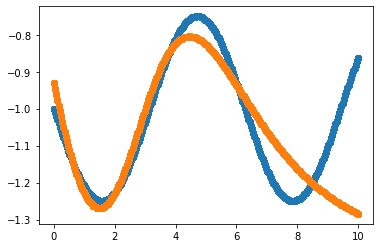

In [16]:
time = X_star[:, 1:2].detach().numpy()
plt.scatter(time, uu_x_true)
plt.scatter(time, learned_func[:, 0:1].detach().numpy())
plt.show()

In [44]:
from pysr import pysr, best

In [46]:
xx = (to_tensor(t, False)/10.0).reshape(-1, 1)
yy = pinn.parametric_func_net(xx)[:, 0:1].detach().numpy()

equations = pysr(
    xx.detach().numpy(),
    yy,
    populations=50,
    niterations=5,
    binary_operators=["+", "*"],
    unary_operators=[
        "sin",
        "cos"
    ]
)

Running on julia -O3 /var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/tmpo0i11pro/runfile.jl
Activating environment on workers.
      From worker 4:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 3:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 5:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 2:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 1.100e+03
Head worker occupation: 4.3%
Progress: 1 / 250 total iterations (0.400%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.002e-02  -0.000e+00  -1.0908816
5           4.127e-04  9.705e-01  (-0.8492799 + (-0.48320252 * x0))
6

In [49]:
best(equations)

-0.56759363*sin(x0) - 0.8300467